In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [2]:
# -----------------------------
# add "src" as import path
path = os.path.join('/home/tsuyoshi/test_bilinear')
sys.path.append(path)

In [3]:
#import models.convolution_lstm_mod
import rev_bilinear
from rev_bilinear_interp import RevBilinear

In [4]:
sys.path

['/home/tsuyoshi/local_transformation_model/notebook',
 '/home/tsuyoshi/miniconda3/envs/pytorch/lib/python37.zip',
 '/home/tsuyoshi/miniconda3/envs/pytorch/lib/python3.7',
 '/home/tsuyoshi/miniconda3/envs/pytorch/lib/python3.7/lib-dynload',
 '',
 '/home/tsuyoshi/miniconda3/envs/pytorch/lib/python3.7/site-packages',
 '/home/tsuyoshi/miniconda3/envs/pytorch/lib/python3.7/site-packages/pretrainedmodels-0.7.4-py3.7.egg',
 '/home/tsuyoshi/miniconda3/envs/pytorch/lib/python3.7/site-packages/munch-2.5.1.dev12-py3.7.egg',
 '/home/tsuyoshi/miniconda3/envs/pytorch/lib/python3.7/site-packages/grid_average-0.0.0-py3.7-linux-x86_64.egg',
 '/home/tsuyoshi/miniconda3/envs/pytorch/lib/python3.7/site-packages/rev_trilinear-0.0.0-py3.7-linux-x86_64.egg',
 '/home/tsuyoshi/miniconda3/envs/pytorch/lib/python3.7/site-packages/rev_bilinear-0.0.0-py3.7-linux-x86_64.egg',
 '/home/tsuyoshi/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions',
 '/home/tsuyoshi/.ipython',
 '/home/tsuyoshi/test_

In [5]:
# define size
height = 50
width = 50
# define position of circle
ic = 25
jc = 25
# spatial scale
scale = 5

In [6]:
# create initial field
R = torch.zeros(1,1,height,width)
# create xy grid
xx = torch.arange(0, width).view(1, -1).repeat(height, 1).float()
yy = torch.arange(0, height).view(-1, 1).repeat(1, width).float()
# create circular field
R[0,0,:,:] = torch.exp(-((xx-ic)**2 + (yy-jc)**2)/scale**2)

Define point cloud with 2d initialization

In [7]:
# define point cloud size
Npc = 1000

In [8]:
# torch.rand generates uniform [0,1)
XYZ = torch.rand(1, 3, Npc, dtype=torch.float32, requires_grad=True).cuda()
# force z value to zero
XYZ[:,2,:] = 0
XYZ = XYZ * height # Scale to uniform [0,height]

In [9]:
XYZ[:,2,:]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [10]:
R = torch.zeros(1,1,Npc).cuda()

In [11]:
# create circular field
R[0,0,:] = torch.exp(-((XYZ[0,0,:]-ic)**2 + (XYZ[0,1,:]-jc)**2)/scale**2)

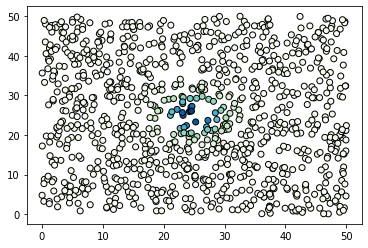

In [12]:
# test plot
x = XYZ[0,0,:].detach().cpu().numpy()
y = XYZ[0,1,:].detach().cpu().numpy()
value = R[0,0,:].detach().cpu().numpy()
plt.scatter(x, y, c=value, cmap="GnBu", edgecolors="black")

In [13]:
# scale to [-1,1]
#XYZ_scl = XYZ/25.0*2.0-1.0
XYZ_scl = XYZ/50.0
torch.min(XYZ_scl),torch.max(XYZ_scl)

(tensor(0., device='cuda:0', grad_fn=<MinBackward1>),
 tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>))

In [23]:
# apply interpolation
Rgrd = RevBilinear.apply(XYZ_scl, R, 20)

In [24]:
Rgrd.shape

torch.Size([1, 1, 20, 20])

In [25]:
# plot a 2-d field
def plot_field(X,title,vmin=0,vmax=1):
    plt.imshow(X,vmin=vmin,vmax=vmax,cmap="GnBu",origin='lower')
    plt.colorbar()
    plt.grid()
    plt.title(title)
    plt.show()

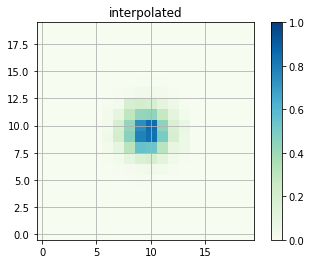

In [26]:
# plot on a grid
plot_field(Rgrd[0,0,:,:].detach().cpu().numpy(),"interpolated")

In [27]:
torch.max(Rgrd)

tensor(0.8530, device='cuda:0', grad_fn=<MaxBackward1>)

In [28]:
torch.min(Rgrd)

tensor(1.1881e-20, device='cuda:0', grad_fn=<MinBackward1>)